Selected Channels from .sfp: ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E24', 'E25', 'E26', 'E27', 'E28', 'E29', 'E30', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E61', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E83', 'E84', 'E85', 'E86', 'E87', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E105', 'E106', 'E107', 'E108', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E115', 'E116', 'E117', 'E118', 'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'Cz']
Channel Coordinates Shape: (125, 3)
Loading D:\Imputed_file\song21_Imputed.mat..

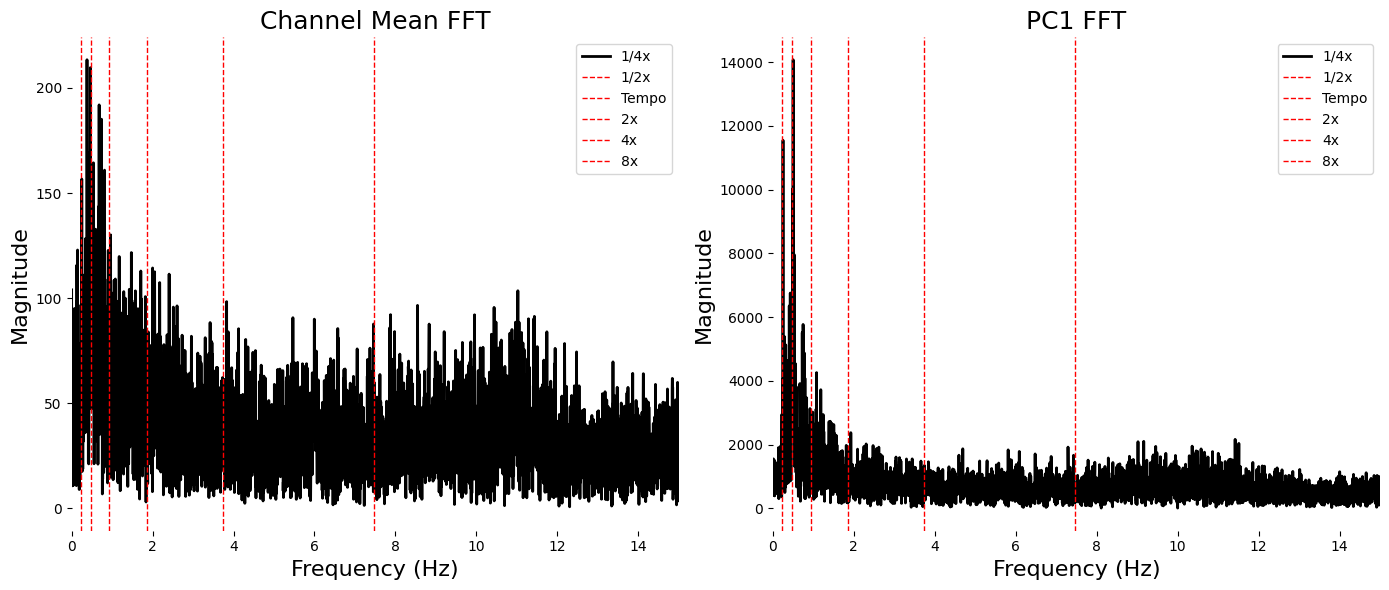

<Figure size 600x600 with 0 Axes>

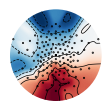

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

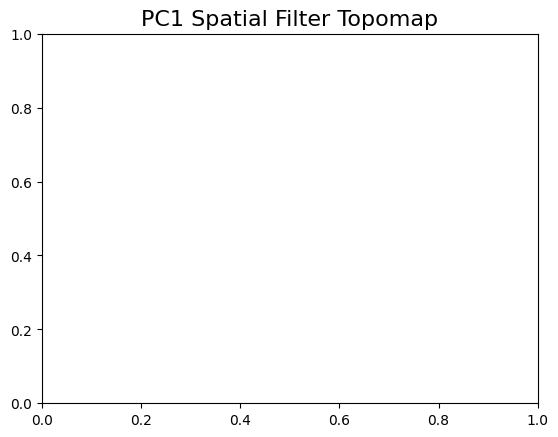

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
from numpy.fft import fft
import mne

# ------------------------------------------------------------
# 1. Setup and Define Directories
# ------------------------------------------------------------

# Define directories
inDir = r'D:\Imputed_file'  # EEG data folder
miscDir = r'D:\Code\Misc'   # Misc folder

# Parameters
fs = 125  # Sampling frequency in Hz
sec_start = 15  # Start time in seconds
epoch_len_sec = 4 * 60  # Epoch length in seconds (4 minutes)
epoch_len_samp = fs * epoch_len_sec  # Epoch length in samples

# ------------------------------------------------------------
# 2. Load Tempo Data
# ------------------------------------------------------------

# Load tempo data from 'tempoHz.mat'
tempo_mat_path = os.path.join(miscDir, 'tempoHz.mat')
if not os.path.exists(tempo_mat_path):
    raise FileNotFoundError(f"'{tempo_mat_path}' does not exist.")

tempo_mat = loadmat(tempo_mat_path)

# Extract 'tempoHz' variable; adjust the key if different
if 'tempoHz' in tempo_mat:
    tempoHz = tempo_mat['tempoHz'].flatten()  # Convert to 1D array
else:
    raise KeyError("'tempoHz' variable not found in 'tempoHz.mat'.")

# Create tempoMatrix similar to MATLAB's:
# tempoMatrix = repmat(tempoHz, 6, 1) .* repmat(2.^(-2:3)', 1, 10);
# Since we're processing only one song, adjust accordingly
scaling_factors = 2.0 ** np.arange(-2, 4)  # Ensure base is float: [0.25, 0.5, 1, 2, 4, 8]
tempoMatrix = np.outer(scaling_factors, tempoHz[:1])  # Shape: (6, 1)

# ------------------------------------------------------------
# 3. Read .sfp File and Create Channel Mapping
# ------------------------------------------------------------

def read_sfp_file(sfp_path, channels_to_select):
    """
    Reads an .sfp file and extracts specified channels.

    Parameters:
    - sfp_path (str): Path to the .sfp file.
    - channels_to_select (list or array): List of channel indices to select (1-based).

    Returns:
    - channel_names (list): List of selected channel names.
    - channel_coords (np.ndarray): Array of channel coordinates (x, y, z).
    """
    if not os.path.exists(sfp_path):
        raise FileNotFoundError(f"Sensor file '{sfp_path}' not found.")

    # Initialize lists to store channel names and coordinates
    names = []
    coords = []

    with open(sfp_path, 'r') as file:
        lines = file.readlines()

    # Iterate over lines and extract channel information
    for idx, line in enumerate(lines, start=1):
        # Skip empty lines or comments
        if not line.strip() or line.startswith('#'):
            continue

        parts = line.strip().split()
        if len(parts) < 4:
            continue  # Not enough data

        name, x, y, z = parts[:4]
        names.append(name)
        coords.append([float(x), float(y), float(z)])

    # Convert to numpy arrays for easier indexing
    names = np.array(names)
    coords = np.array(coords)

    # Adjust for 1-based indexing (MATLAB) to 0-based (Python)
    selected_indices = [i - 1 for i in channels_to_select]
    selected_names = names[selected_indices]
    selected_coords = coords[selected_indices]

    return selected_names.tolist(), selected_coords

def create_custom_montage(data_channel_names, sfp_channel_coords):
    """
    Creates a custom montage mapping data channels to their spatial coordinates.

    Parameters:
    - data_channel_names (list): List of data channel names ('Ch1' to 'Ch125').
    - sfp_channel_coords (np.ndarray): Array of channel coordinates (x, y, z).

    Returns:
    - montage (mne.channels.DigMontage): Custom montage object.
    """
    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({
        'ch_name': data_channel_names,
        'x': sfp_channel_coords[:, 0],
        'y': sfp_channel_coords[:, 1],
        'z': sfp_channel_coords[:, 2]
    })

    # Create a dictionary for channel positions
    ch_pos = {row['ch_name']: [row['x'], row['y'], row['z']] for _, row in df.iterrows()}

    # Create the montage
    montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')

    return montage

# Path to the .sfp file
sfp_file = os.path.join(miscDir, 'Hydrocel GSN 128 1.0.sfp')

# Channels to select (4:127 and 132 in MATLAB are 1-based)
channels_to_select = list(range(4, 128)) + [132]

# Read the .sfp file
channel_names_sfp, channel_coords_sfp = read_sfp_file(sfp_file, channels_to_select)

print(f"Selected Channels from .sfp: {channel_names_sfp}")
print(f"Channel Coordinates Shape: {channel_coords_sfp.shape}")

# Generate data channel names
data_channel_names = [f'Ch{i}' for i in range(1, 126)]  # 'Ch1' to 'Ch125'

# Ensure the number of selected channels matches your data
if len(channel_names_sfp) != len(data_channel_names):
    raise ValueError("Number of selected channels does not match the number of data channels.")

# Create a custom montage
montage = create_custom_montage(data_channel_names, channel_coords_sfp)

# ------------------------------------------------------------
# 4. Load and Preprocess EEG Data for the First Song
# ------------------------------------------------------------

# Specify the first song number
song_number = 21  # First song is 'song21_Imputed.mat'

# Construct the file path
currFn = f'song{song_number}_Imputed.mat'
file_path = os.path.join(inDir, currFn)

if not os.path.exists(file_path):
    raise FileNotFoundError(f"EEG data file '{file_path}' does not exist.")

print(f'Loading {file_path}...')

# Load the EEG data
data_mat = loadmat(file_path)

# Extract the data variable; adjust the key if different
data_key = f'data{song_number}'
if data_key not in data_mat:
    raise KeyError(f"Variable '{data_key}' not found in '{currFn}'.")

data = data_mat[data_key]  # Expected shape: (channels, time, participants)

# ------------------------------------------------------------
# 5. Apply DC Correction
# ------------------------------------------------------------

def median_dc_correct(data):
    """
    Apply median DC correction across participants for each channel and time point.

    Parameters:
    - data: np.ndarray of shape (channels, time, participants) or (channels, time)

    Returns:
    - corrected_data: np.ndarray of the same shape as 'data'
    """
    if data.ndim == 3:
        median_vals = np.median(data, axis=2, keepdims=True)  # Shape: (channels, time, 1)
        corrected_data = data - median_vals
    elif data.ndim == 2:
        median_vals = np.median(data, axis=1, keepdims=True)  # Shape: (channels, 1)
        corrected_data = data - median_vals
    else:
        raise ValueError("Data must be 2D or 3D array.")
    return corrected_data

# Apply DC correction
tempX_dc = median_dc_correct(data)  # Shape: (channels, time, participants)

# ------------------------------------------------------------
# 6. Extract Epoch and Compute Mean Across Participants
# ------------------------------------------------------------

# Define epoch boundaries
start_sample = sec_start * fs
end_sample = start_sample + epoch_len_samp

# Extract the epoch
tempX_epoch = tempX_dc[:, start_sample:end_sample, :]  # Shape: (channels, T, participants)

# Check if epoch length is correct
if tempX_epoch.shape[1] != epoch_len_samp:
    raise ValueError(f"Extracted epoch length {tempX_epoch.shape[1]} does not match expected {epoch_len_samp} samples.")

# Compute mean across participants
mean_data = np.mean(tempX_epoch, axis=2)  # Shape: (channels, T)

# Apply DC correction again on the mean data
trial_mean_data = median_dc_correct(mean_data)  # Shape: (channels, T)

# ------------------------------------------------------------
# 7. Perform PCA
# ------------------------------------------------------------

# Number of channels and time points
nChan, T = trial_mean_data.shape
nSongs = 1  # Only one song

# Perform PCA on the transposed data (features x samples)
pca = PCA(n_components=1)
pca.fit(trial_mean_data.T)  # Shape: (T, channels)

# Extract the first principal component (PC1)
U = pca.components_.T  # Shape: (channels, 1)
concatPC1 = U.T @ trial_mean_data  # Shape: (1, T)
PC1 = concatPC1.flatten()  # Shape: (T,)

# ------------------------------------------------------------
# 8. Compute FFT
# ------------------------------------------------------------

# Compute FFT for channel means
channel_means = np.mean(trial_mean_data, axis=0)  # Shape: (T,)
CH_fft = np.abs(fft(channel_means))  # Shape: (T,)

# Compute FFT for PC1
PC1_fft = np.abs(fft(PC1))  # Shape: (T,)

# Frequency axis
freqs = np.fft.fftfreq(T, d=1/fs)  # Shape: (T,)
positive_freqs = freqs >= 0
freqs = freqs[positive_freqs]
CH_fft = CH_fft[positive_freqs]
PC1_fft = PC1_fft[positive_freqs]

# ------------------------------------------------------------
# 9. Visualization: Magnitude Spectra
# ------------------------------------------------------------

plt.figure(figsize=(14, 6))

# Plot Channel Mean FFT
plt.subplot(1, 2, 1)
plt.plot(freqs, CH_fft, 'k', linewidth=2, label='Channel Mean')
for idx, tempo in enumerate(tempoMatrix[:, 0]):
    plt.axvline(x=tempo, color='r', linestyle='--', linewidth=1)
plt.xlim(xl := [0, 15])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)
plt.title('Channel Mean FFT', fontsize=18)
plt.legend(['1/4x', '1/2x', 'Tempo', '2x', '4x', '8x'], loc='upper right')
plt.grid(False)
plt.box(False)

# Plot PC1 FFT
plt.subplot(1, 2, 2)
plt.plot(freqs, PC1_fft, 'k', linewidth=2, label='PC1')
for idx, tempo in enumerate(tempoMatrix[:, 0]):
    plt.axvline(x=tempo, color='r', linestyle='--', linewidth=1)
plt.xlim(xl)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Magnitude', fontsize=16)
plt.title('PC1 FFT', fontsize=18)
plt.legend(['1/4x', '1/2x', 'Tempo', '2x', '4x', '8x'], loc='upper right')
plt.grid(False)
plt.box(False)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 10. Visualization: Topomap of PC1 Spatial Filter
# ------------------------------------------------------------

# Create MNE Info object with correct channel names
info = mne.create_info(ch_names=data_channel_names, sfreq=fs, ch_types='eeg')

# Assign the custom montage to the info object
info.set_montage(montage)

# Flatten the first principal component and ensure its length matches the number of channels
pc1_data = U.flatten()

if len(pc1_data) != len(info['ch_names']):
    raise ValueError(f"Mismatch: PC1 data has {len(pc1_data)} entries, but info object has {len(info['ch_names'])} channels.")

# Plot topomap for PC1 spatial filter
plt.figure(figsize=(6, 6))


mne.viz.plot_topomap(pc1_data, info, show=True)

# Set the title and colorbar
plt.title('PC1 Spatial Filter Topomap', fontsize=16)
plt.colorbar(label='Amplitude')  # Make sure colorbar is meaningful

plt.show()



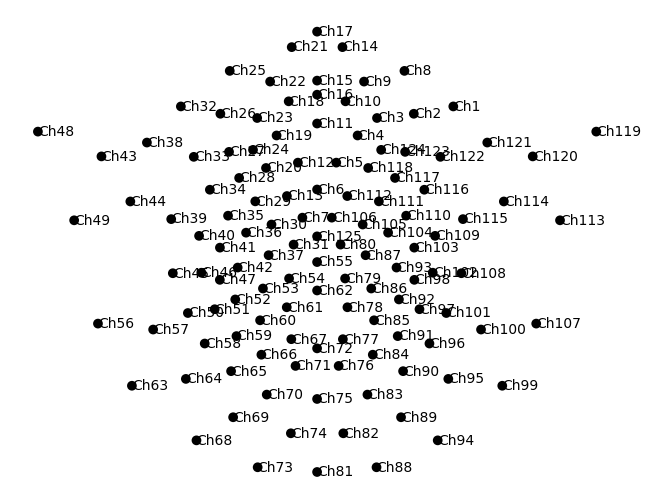

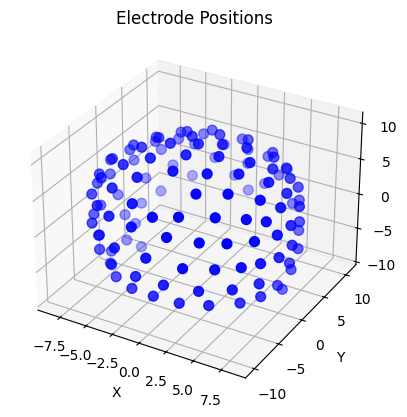

In [2]:
# Visualize montage in 2D
mne.viz.plot_montage(montage, show_names=True)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(channel_coords_sfp[:, 0], channel_coords_sfp[:, 1], channel_coords_sfp[:, 2], s=50, c='b')
ax.set_title('Electrode Positions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


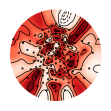

(<matplotlib.image.AxesImage at 0x17854eb9310>,
 <matplotlib.contour.QuadContourSet at 0x17854ea4710>)

In [3]:
import numpy as np
data = np.random.rand(len(info['ch_names']))  # Synthetic data
mne.viz.plot_topomap(data, info)


In [4]:
print(info['ch_names'])


['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8', 'Ch9', 'Ch10', 'Ch11', 'Ch12', 'Ch13', 'Ch14', 'Ch15', 'Ch16', 'Ch17', 'Ch18', 'Ch19', 'Ch20', 'Ch21', 'Ch22', 'Ch23', 'Ch24', 'Ch25', 'Ch26', 'Ch27', 'Ch28', 'Ch29', 'Ch30', 'Ch31', 'Ch32', 'Ch33', 'Ch34', 'Ch35', 'Ch36', 'Ch37', 'Ch38', 'Ch39', 'Ch40', 'Ch41', 'Ch42', 'Ch43', 'Ch44', 'Ch45', 'Ch46', 'Ch47', 'Ch48', 'Ch49', 'Ch50', 'Ch51', 'Ch52', 'Ch53', 'Ch54', 'Ch55', 'Ch56', 'Ch57', 'Ch58', 'Ch59', 'Ch60', 'Ch61', 'Ch62', 'Ch63', 'Ch64', 'Ch65', 'Ch66', 'Ch67', 'Ch68', 'Ch69', 'Ch70', 'Ch71', 'Ch72', 'Ch73', 'Ch74', 'Ch75', 'Ch76', 'Ch77', 'Ch78', 'Ch79', 'Ch80', 'Ch81', 'Ch82', 'Ch83', 'Ch84', 'Ch85', 'Ch86', 'Ch87', 'Ch88', 'Ch89', 'Ch90', 'Ch91', 'Ch92', 'Ch93', 'Ch94', 'Ch95', 'Ch96', 'Ch97', 'Ch98', 'Ch99', 'Ch100', 'Ch101', 'Ch102', 'Ch103', 'Ch104', 'Ch105', 'Ch106', 'Ch107', 'Ch108', 'Ch109', 'Ch110', 'Ch111', 'Ch112', 'Ch113', 'Ch114', 'Ch115', 'Ch116', 'Ch117', 'Ch118', 'Ch119', 'Ch120', 'Ch121', 'Ch122', 'Ch123', 

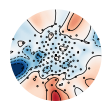

(<matplotlib.image.AxesImage at 0x17857709310>,
 <matplotlib.contour.QuadContourSet at 0x178577d1c50>)

In [5]:
real_data = np.mean(trial_mean_data, axis=1)  # Take the mean over time
mne.viz.plot_topomap(real_data, info)
